# UMM-CV4

### Imports

In [1]:
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import curve_fit
import pandas as pd
import csv
from numpy import genfromtxt
from math import pi
import Noise_Referral as nr
import Pseudo_Noise_Time_Domain as pn
import pickle as pkl
plt.ion()
plt.rcParams.update({'font.size': 22,'legend.fontsize': 16})
dirname = '/home/msilvafe/readout-script-dev/Noise/'

### Define Resonator/Assembly Parameters

In [2]:
f_min = 4e9
f_max = 6e9
P_feed = -75
Dip_dB = -6.4
BW = 67e3
dfdI = 0.02
LNA_TN= [2.1,40.,191.]

f_mean = (f_min + f_max)/2
Dip_lin = 10**(Dip_dB/20)
#Note Heather's fitting code has BW = f/2Q
Qr = f_mean/(2*BW)
#Qr = 30756
Qc = Qr/(1-Dip_lin)
#Qc = 53500
Qi = 1/((1/Qr)-(1/Qc))
print(f'Qr: {int(Qr)}, Qc: {int(Qc)}, Qi: {int(Qi)}')
print(20*np.log10(1-(Qr/Qc)))
print(4e9/Qr)

Qr: 37313, Qc: 71568, Qi: 77958
-6.4
107200.0


Read in Pton input coax chain

In [7]:
c = pd.read_csv(dirname+'InputChain.csv', delimiter=',')
d = np.transpose(c.values)
compin = d[0,:]
lossin = d[1,:]
Tavgin = (d[2,:]+d[3,:])/2
coax_YNin = d[4,:]
coax_typein = d[5,:]
coax_lin = d[6,:]
for i in range(len(compin)):
    if coax_YNin[i] == 'Y':
        t = nr.readcoax(dirname+coax_typein[i]+'.csv',6)
        lossin[i] = (t[0]*Tavgin[i]+t[1])*coax_lin[i]

In [6]:
print(np.sum(lossin))
lossin4 = np.copy(lossin)
for i in range(len(compin)):
    if coax_YNin[i] == 'Y':
        t = nr.readcoax(dirname+coax_typein[i]+'.csv',6)
        lossin4[i] = (t[0]*Tavgin[i]+t[1])*coax_lin[i]
print(np.sum(lossin4))

30.48331082159738
30.48331082159738


In [8]:
def find_P_in_from_P_feed(P_feed,f_r):
    lossout = np.copy(lossin)
    for i in range(len(compin)):
        if coax_YNin[i] == 'Y':
            t = nr.readcoax(dirname+coax_typein[i]+'.csv',f_r/1e9)
            lossout[i] = (t[0]*Tavgin[i]+t[1])*coax_lin[i]
    P_in = P_feed + np.sum(lossout)
    return lossout, Tavgin, P_in

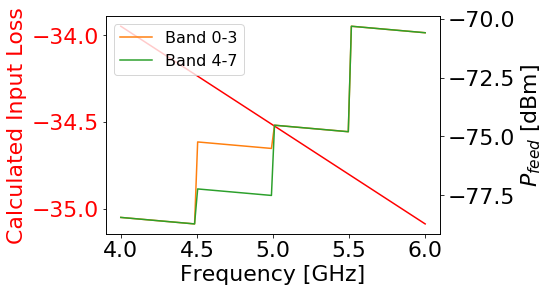

In [70]:
uc_atts = [27, 20, 18, 9, 27, 24, 18, 9]
outsmurf = -31
f_plot = np.linspace(4e9,6e9,100)
loss_plot = []
for f in f_plot:
    loss, _,_ = find_P_in_from_P_feed(-75,f)
    loss_plot.append(np.sum(loss))
loss_plot = np.asarray(loss_plot)

P_feed_0_to_3 = np.zeros(len(f_plot))
P_feed_4_to_7 = np.zeros(len(f_plot))
P_feed_0_to_3[np.where(f_plot < 4.5e9)[0]] = -loss_plot[np.where(f_plot < 4.5e9)[0]]+outsmurf-uc_atts[0]*0.5
P_feed_4_to_7[np.where(f_plot < 4.5e9)[0]] = -loss_plot[np.where(f_plot < 4.5e9)[0]]+outsmurf-uc_atts[4]*0.5
P_feed_0_to_3[np.where((f_plot > 4.5e9) & (f_plot <5e9))[0]] = -loss_plot[np.where((f_plot > 4.5e9) & (f_plot <5e9))[0]]+outsmurf-uc_atts[1]*0.5
P_feed_4_to_7[np.where((f_plot > 4.5e9) & (f_plot <5e9))[0]] = -loss_plot[np.where((f_plot > 4.5e9) & (f_plot <5e9))[0]]+outsmurf-uc_atts[5]*0.5
P_feed_0_to_3[np.where((f_plot > 5e9) & (f_plot <5.5e9))[0]] = -loss_plot[np.where((f_plot > 5e9) & (f_plot <5.5e9))[0]]+outsmurf-uc_atts[2]*0.5
P_feed_4_to_7[np.where((f_plot > 5e9) & (f_plot <5.5e9))[0]] = -loss_plot[np.where((f_plot > 5e9) & (f_plot <5.5e9))[0]]+outsmurf-uc_atts[6]*0.5
P_feed_0_to_3[np.where(f_plot > 5.5e9)[0]] = -loss_plot[np.where(f_plot > 5.5e9)[0]]+outsmurf-uc_atts[3]*0.5
P_feed_4_to_7[np.where(f_plot > 5.5e9)[0]] = -loss_plot[np.where(f_plot > 5.5e9)[0]]+outsmurf-uc_atts[7]*0.5

fig,ax1 = plt.subplots()
plt.xlabel('Frequency [GHz]')
ax1.plot(f_plot/1e9,-loss_plot,color = 'r')
ax1.set_ylabel('Calculated Input Loss',color = 'r')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2.plot(f_plot/1e9,P_feed_0_to_3,color = 'C1')
ax2.plot(f_plot/1e9,P_feed_4_to_7,color = 'C2')
plt.ylabel('$P_{feed}$ [dBm]')

ax2.legend(['Band 0-3','Band 4-7'])
P_band = {}
P_band[0] = np.mean(P_feed_0_to_3[np.where((f_plot > 4e9)&(f_plot<4.5e9))])
P_band[1] = np.mean(P_feed_0_to_3[np.where((f_plot > 4.5e9)&(f_plot<5e9))])
P_band[2] = np.mean(P_feed_0_to_3[np.where((f_plot > 5e9)&(f_plot<5.5e9))])
P_band[3] = np.mean(P_feed_0_to_3[np.where((f_plot > 5.5e9)&(f_plot<6e9))])
P_band[4] = np.mean(P_feed_4_to_7[np.where((f_plot > 4e9)&(f_plot<4.5e9))])
P_band[5] = np.mean(P_feed_4_to_7[np.where((f_plot > 4.5e9)&(f_plot<5e9))])
P_band[6] = np.mean(P_feed_4_to_7[np.where((f_plot > 5e9)&(f_plot<5.5e9))])
P_band[7] = np.mean(P_feed_4_to_7[np.where((f_plot > 5.5e9)&(f_plot<6e9))])

In [9]:
f = 5.75e9
lossin, _, P_in = find_P_in_from_P_feed(P_feed, f)
print(f"Total Input Loss: {np.sum(lossin)} at {f/1e9} GHz")
print(f"P_in: {P_in}")

Total Input Loss: 30.267751824763668 at 5.75 GHz
P_in: -44.732248175236336


In [72]:
_,_,Pin4 = find_P_in_from_P_feed(-70,4e9)
_,_,Pin6 = find_P_in_from_P_feed(-70,6e9)
print(-34-0.5*9)
print(Pin4)
#Band 0 = -81.5 dBm, drive = 12, uc_att = 27
#Band 1 = -78.5 dBm, drive = 12, uc_att = 20
#Band 2 = -77.5 dBm, drive = 12, uc_att = 18
#Band 3 = -73.5 dBm, drive = 12, uc_att = 9

-38.5
-36.051484877287606


Read in Pton output coax chain

In [178]:
c = pd.read_csv(dirname+'Pton_Output.csv',delimiter=',')
d = np.transpose(c.values)
compout = d[0,:]
lossout = d[1,:]
Tavgout = (d[2,:]+d[3,:])/2
coax_YNout = d[4,:]
coax_typeout = d[5,:]
coax_lout = d[6,:]
Gtot = 0.
for i in range(len(compout)):
    if coax_YNout[i] == 'Y':
        t = nr.readcoax(dirname+coax_typeout[i]+'.csv',6)
        lossout[i] = (t[0]*Tavgout[i]+t[1])*coax_lout[i]

Calculate 300K referred as a check

In [74]:
T_300K_Referred = nr.ref_noise_temp(lossin,Tavgin,300.)
print('300K referred =', np.round(T_300K_Referred,2), 'K')

300K referred = 0.96 K


Calculate DAC Noise Temperature

In [130]:
T_DAC = nr.refer_phase_noise_to_K(100,lossin,Tavgin,P_in,Qr,Qc,f_mean,dfdI)
print(T_DAC)

230.0099131358713


Calculate HEMT Noise Temperature

In [179]:
T_HEMT = nr.Amp_Chain_Noise_Temp(lossout, Tavgout, LNA_TN)
print(T_HEMT)

3.1012340875532907


### Nonlinearity noise vs N_tones

Define some non-linearity params

In [41]:
def nl_fit_fn(x,a):
    return a*x**3

In [42]:
IIP3 = -30
N_tones_sweep = np.logspace(1,3,5).astype(int)
out_dict = {}
P_feeds = [-95,-85,-75,-65]

for P_feed in P_feeds:
    out_dict = {}
    out_dict['P_feed'] = P_feed
    temp_vs_ntones = []
    for N_tones in N_tones_sweep:
        out_dict[N_tones] = {}
        print(f'Generating Comb for {N_tones} tones')
        Qrs, Qcs, f_res, t, f, V_wave_in, V_wave_out = pn.Gen_Fake_Comb(P_dBm = P_feed, 
                                                                        f_start = f_min, f_stop = f_max, 
                                                                        N_Tones = N_tones,
                                                                        separation_scatter = 0, 
                                                                        BW = 2*BW,BW_scatter = 0,
                                                                        Depth = Dip_dB, Depth_Scatter = 0, 
                                                                        T = 0.0001)

        out_dict[N_tones]['Qrs'] = Qrs
        out_dict[N_tones]['Qcs'] = Qcs
        out_dict[N_tones]['f_res'] = f_res
        out_dict[N_tones]['t'] = t
        out_dict[N_tones]['f'] = f
        out_dict[N_tones]['V_wave_in'] = V_wave_in
        out_dict[N_tones]['V_wave_out'] = V_wave_out

        print(f'Calc nonlinearities for {N_tones} tones')
        outdict = pn.Calc_Non_Linearities(V_wave_in,V_wave_out,t,f,
                                     fres = f_res,
                                     Gain = 40, IIP3 = IIP3, 
                                     plot_all = False,
                                     plot_noise_temp = True, 
                                     label = '',
                                     alpha = 0.8, fig_num = 2)

        out_dict[N_tones]['NL_dict'] = outdict

        f_plot = outdict['ADC']['f_WperHz']
        T_plot = outdict['ADC']['K']
        f_plot = f_plot[:len(f_plot)//2]
        T_plot = T_plot[:len(T_plot)//2]
        fplot3 = f_plot[np.where((f_plot > f_min) & (f_plot < f_max))[0]]
        Tplot3 = T_plot[np.where((f_plot > f_min) & (f_plot < f_max))[0]]
        print(f'Noise from for {N_tones} tones: {np.mean(Tplot3)} K')
        temp_vs_ntones.append(np.mean(Tplot3))
    out_dict['Noise_Temps'] = temp_vs_ntones
    popt,_ = curve_fit(nl_fit_fn,N_tones_sweep, temp_vs_ntones)
    out_dict['a'] = popt[0]
    pkl.dump(out_dict,open(f'/home/msilvafe/Documents/Cv4_for_Delta_Review/P_feed_{P_feed}_fake_comb.pkl','wb'))

Generating Comb for 10 tones
Calc nonlinearities for 10 tones


KeyboardInterrupt: 

Save pickle of non-linearity noise

Noise sources:

In [43]:
out_dict = pkl.load(open(f'/home/msilvafe/Documents/Cv4_for_Delta_Review/P_feed_{-65}_fake_comb.pkl','rb'))

In [44]:
print(out_dict.keys(),'\n')
print(out_dict['Noise_Temps'],'\n')
print(out_dict[1000].keys(),'\n')
print(out_dict[1000]['NL_dict'].keys(),'\n')
print(out_dict[1000]['NL_dict']['In'].keys(),'\n')
print(out_dict[1000]['NL_dict']['ADC'].keys(),'\n')

dict_keys(['P_feed', 10, 31, 100, 316, 1000, 'Noise_Temps', 'a']) 

[0.007246955309007201, 0.09463691363052387, 5.66143587493927, 154.62739634196214, 3375.3177535940245] 

dict_keys(['Qrs', 'Qcs', 'f_res', 't', 'f', 'V_wave_in', 'V_wave_out', 'NL_dict']) 

dict_keys(['In', 'Out', 'ADC']) 

dict_keys(['f', 't', 'dBm', 'Volts']) 

dict_keys(['f_WperHz', 'WperHz', 'K', 'Gain_nl', 'f', 't', 'dBm', 'Volts']) 



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Text(0.5, 0, 'Frequency [GHz]')

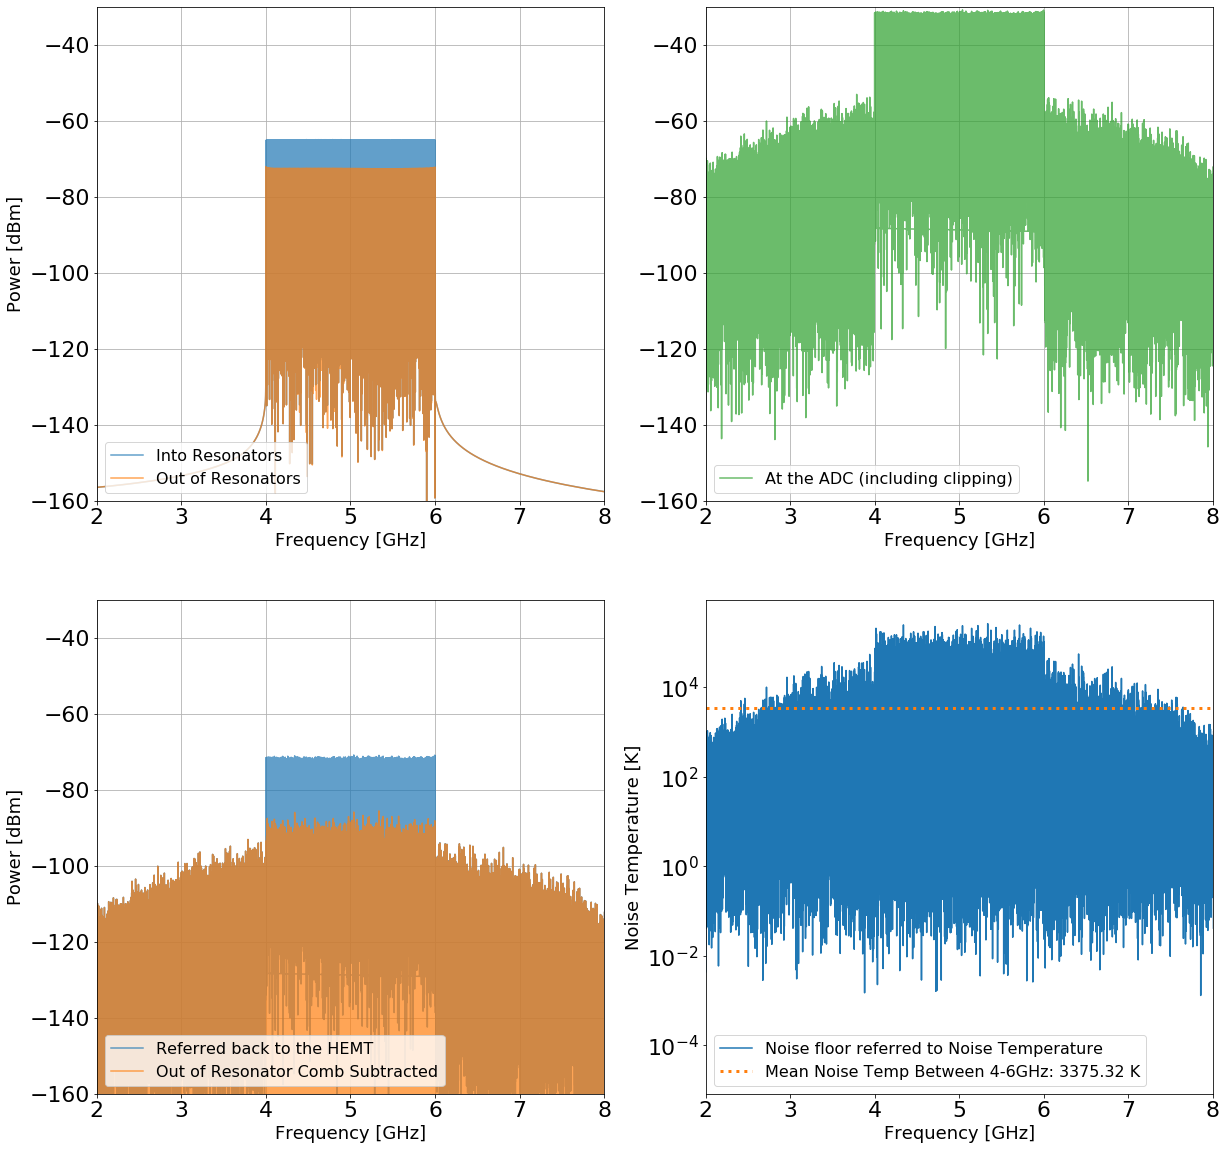

In [33]:
plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.plot(out_dict[1000]['NL_dict']['In']['f']/1e9,out_dict[1000]['NL_dict']['In']['dBm'],
         alpha = 0.7,label = 'Into Resonators')
plt.plot(out_dict[1000]['NL_dict']['Out']['f']/1e9,out_dict[1000]['NL_dict']['Out']['dBm'],
         alpha = 0.7,label = 'Out of Resonators')
plt.xlim(2,8)
plt.legend(loc = 'lower left')
plt.xlabel('Frequency [GHz]',fontsize = 18)
plt.ylabel('Power [dBm]',fontsize = 18)
plt.ylim(-160,-30)
plt.grid()

#plt.figure(figsize = (10,10))
plt.subplot(2,2,2)
plt.plot(out_dict[1000]['NL_dict']['ADC']['f']/1e9,
         out_dict[1000]['NL_dict']['ADC']['dBm'],
         alpha = 0.7,label = 'At the ADC (including clipping)',
         color = 'C2')
plt.legend(loc = 'lower left')
plt.xlabel('Frequency [GHz]',fontsize = 18)
#plt.ylabel('Power [dBm]')
plt.xlim(2,8)
plt.ylim(-160,-30)
plt.grid()

plt.subplot(2,2,3)
V_ADC_ref = (2*np.abs(np.fft.fft(out_dict[1000]['NL_dict']['ADC']['Volts']))/len(out_dict[1000]['NL_dict']['ADC']['Volts'])/out_dict[1000]['NL_dict']['ADC']['Gain_nl'])
V_out_fft_norm = 2*np.abs(np.fft.fft(out_dict[1000]['NL_dict']['Out']['Volts']))/len(out_dict[1000]['NL_dict']['Out']['Volts'])
plt.plot(out_dict[1000]['NL_dict']['ADC']['f']/1e9,
         10*np.log10((V_ADC_ref/np.sqrt(2))**2/50/0.001),
         label = 'Referred back to the HEMT',
         color = 'C0',alpha = 0.7)
plt.xlim(2,8)
plt.ylim(-160,-30)
            
V_ADC_ref2 = V_ADC_ref - V_out_fft_norm
plt.subplot(2,2,3)
plt.plot(out_dict[1000]['NL_dict']['ADC']['f']/1e9,
         10*np.log10((V_ADC_ref2/np.sqrt(2))**2/50/0.001),
         label = 'Out of Resonator Comb Subtracted',
         color = 'C1', alpha = 0.7)
plt.xlim(2,8)
plt.ylim(-160,-30)
plt.legend(loc = 'lower left')

f = out_dict[1000]['NL_dict']['ADC']['f']
kb = 1.38064852e-23
Z_0 = 50.
NL_HEMT_dBm = 10*np.log10((V_ADC_ref2/np.sqrt(2))**2/Z_0/.001)
if (len(f)%10) == 0:
    f_new = f
if (len(f)%10) != 0:
    f_new = f[0:-(len(f)%10)]
    NL_HEMT_dBm = NL_HEMT_dBm[0:-(len(f)%10)]
NL_HEMT_W = 0.001*(10**(NL_HEMT_dBm/10))
f_WperHz = np.zeros(int(len(f_new)/10))
NL_HEMT_WperHz = np.zeros(int(len(f_new)/10))
for i in range(len(f_WperHz)):
    f_WperHz[i] = np.mean(f_new[10*i:10*i+9])
    NL_HEMT_WperHz[i] = np.mean(NL_HEMT_W[10*i:10*i+9])/(f_new[10*i+9]-f_new[10*i])
NL_HEMT_K = NL_HEMT_WperHz/kb
plt.xlabel('Frequency [GHz]',fontsize = 18)
plt.ylabel('Power [dBm]',fontsize = 18)
plt.grid()
    
plt.subplot(2,2,4)
plt.semilogy(f_WperHz/1e9,NL_HEMT_K,
             label = 'Noise floor referred to Noise Temperature',
             color = 'C0')
plt.axhline(out_dict["Noise_Temps"][-1],color = 'C1',
            ls = ':',lw = 3,
           label = f'Mean Noise Temp Between 4-6GHz: {np.round(out_dict["Noise_Temps"][-1],2)} K')
plt.xlim(2,8)
plt.legend(loc = 'lower left')
plt.ylabel('Noise Temperature [K]',fontsize = 18)
plt.xlabel('Frequency [GHz]',fontsize = 18)

In [45]:
NEI_HEMT = nr.TN_to_NEI(T_HEMT,P_feed,Qr,Qc,f_mean,dfdI)
NEI_DAC = nr.TN_to_NEI(T_DAC,P_feed,Qr,Qc,f_mean,dfdI)
N_tones_sweep = np.asarray([10, 31, 100, 316, 1000])
NEI_NL = []
for i in range(len(N_tones_sweep)):
    NEI_NL.append(nr.TN_to_NEI(out_dict['Noise_Temps'],P_feed,Qr,Qc,f_mean,dfdI))
NEI_Tot = np.sqrt(NEI_HEMT**2 + NEI_DAC**2 + np.asarray(NEI_NL)**2)
print(f'HEMT Noise : {NEI_HEMT} pA/rtHz\n')
print(f'DAC Noise: {NEI_DAC} pA/rtHz\n')
print(f'Pseudo Noise: {NEI_NL} pA/rtHz for N_tones: {N_tones_sweep}\n')
print(f'Total Noise: {NEI_Tot} pA/rtHz for N_tones: {N_tones_sweep}\n')

TypeError: can't multiply sequence by non-int of type 'float'

Fit Pseudo-Noise to Model

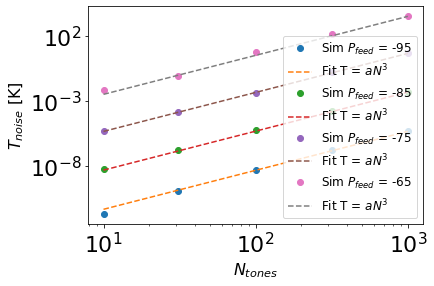

In [46]:
Nplot = np.logspace(1,3,100)
P_feeds = [-95,-85,-75,-65]
a = []
for P in P_feeds:
    temp = pkl.load(open(f'/home/msilvafe/Documents/Cv4_for_Delta_Review/P_feed_{P}_fake_comb.pkl','rb'))
    plt.loglog(N_tones_sweep, temp['Noise_Temps'],'o',
               label = 'Sim $P_{feed}$ = '+ str(P))
    plt.loglog(Nplot,temp['a']*Nplot**3,'--',
               label = 'Fit T = $aN^3$')
    a.append(temp['a'])
plt.xlabel('$N_{tones}$',fontsize = 16)
plt.ylabel('$T_{noise}$ [K]',fontsize = 16)
plt.legend(fontsize = 12)

In [47]:
def cube_fit(x,a):
    return a+3*x

In [48]:
pfit, _ = curve_fit(cube_fit,
                    np.log10(10**(np.asarray(P_feeds)/10)*0.001),
                    np.log10(a))

1.4052833686612166e+23


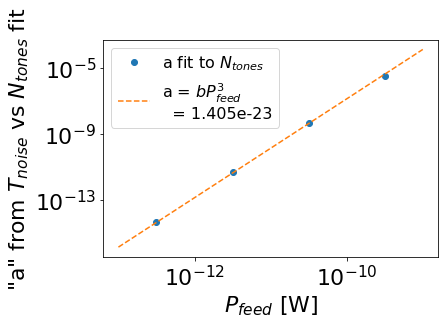

In [49]:
Pplot = np.linspace(-100,-60,100)
plt.loglog(10**(np.asarray(P_feeds)/10)*0.001, a,'o',
           label = 'a fit to $N_{tones}$')
plt.loglog(10**(Pplot/10)*0.001,
           10**(pfit[0])*(10**(Pplot/10)*0.001)**3,'--',
          label = 'a = $bP_{feed}^3$'+f'\n  = {np.round(10**pfit[0]/1e23,3)}e-23')
plt.xlabel('$P_{feed}$ [W]')
plt.ylabel('"a" from $T_{noise}$ vs $N_{tones}$ fit')
plt.legend()
print(10**pfit[0])

Sum: 51.50753465589825
Pseudo Noise: 4.617012477648454
HEMT: 5.815618513186584
DAC: 44.66909801355431
TLS: 24.547089156850298


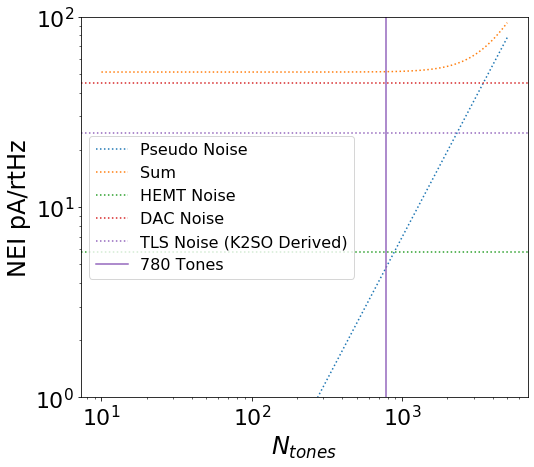

In [77]:
P_feed = -75
f_mean = 5e9
lossin, _, P_in = find_P_in_from_P_feed(P_feed, f_mean)
P_feed_lin = 0.001*10**(P_feed/10)
plt.figure(figsize = (8,7))

N_tones_plot = np.logspace(1,np.log10(5000),100)
TH = T_HEMT
dBc = 101

NEI_HEMT_P = nr.TN_to_NEI(TH,P_feed,Qr,Qc,f_mean,dfdI)

_, _, P_in = find_P_in_from_P_feed(P_feed, f_mean)
T_DAC_P = nr.refer_phase_noise_to_K(dBc,lossin,Tavgin,P_in,Qr,Qc,f_mean,dfdI)
NEI_DAC_P = nr.TN_to_NEI(T_DAC_P,P_feed,Qr,Qc,f_mean,dfdI)

b = 1.4052833686612166e+23
T_NL = b*P_feed_lin**3*N_tones_plot**3
NEI_NL_plot = nr.TN_to_NEI(T_NL,
                           P_feed,Qr,Qc,f_mean,dfdI)

a1=-0.32
b1 = -1.01
#P in mW
NEI_TLS_P = 10**(a1*np.log10(10**(P_feed/10)) + b1)

NEI_tot_plot = np.sqrt(NEI_TLS_P**2 + NEI_HEMT_P**2 + NEI_DAC_P**2 + NEI_NL_plot**2)

#plt.loglog(N_tones_sweep,NEI_NL,'o',color = 'C0')  
plt.loglog(N_tones_plot,NEI_NL_plot,':',color = 'C0',label = 'Pseudo Noise')
plt.loglog(N_tones_plot,NEI_tot_plot,':',color = 'C1',label = 'Sum')
plt.axhline(NEI_HEMT_P,color = 'C2',ls = ':',label = 'HEMT Noise')
plt.axhline(NEI_DAC_P,color = 'C3',ls = ':',label = 'DAC Noise')
plt.axhline(NEI_TLS_P,color = 'C4',ls = ':',label = 'TLS Noise (K2SO Derived)')
plt.axvline(780,color = 'C4',ls = '-',label = '780 Tones')
plt.legend()
#plt.legend(['Pseudo Noise','Sum','HEMT Noise','DAC Noise','850 Tones'])
plt.xlabel('$N_{tones}$',fontsize = 24)
plt.ylabel('NEI pA/rtHz',fontsize = 24)
plt.ylim(1,100)

print(f'Sum: {NEI_tot_plot[np.argmin(np.abs(N_tones_plot - 780))]}')
print(f'Pseudo Noise: {NEI_NL_plot[np.argmin(np.abs(N_tones_plot - 780))]}')
print(f'HEMT: {NEI_HEMT_P}')
print(f'DAC: {NEI_DAC_P}')
print(f'TLS: {NEI_TLS_P}')
#plt.xlim(200,1000)

All else fixed, NEI scales w/ $\sqrt(T_{noise})$

NameError: name 'popt' is not defined

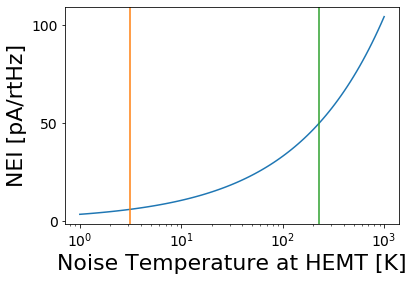

In [52]:
T = np.logspace(0,3,100)
plt.semilogx(T,nr.TN_to_NEI(T,P_feed,Qr,Qc,f_mean,dfdI),'C0')
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
plt.xlabel('Noise Temperature at HEMT [K]')
plt.ylabel('NEI [pA/rtHz]')
plt.axvline(T_HEMT,color = 'C1')
plt.axvline(T_DAC,color = 'C2')
plt.axvline(popt[0]*1000**3,color = 'C3')
plt.grid()

Plot Noise Sources vs P_feed

Frequency: 5.0 GHz
TLS: 24.274568300846056
DAC: 30.778149018562655
PNL: 4.513347406295123
Total: 39.46884062098279
37313.432835820895 71568.06000186627


Text(0, 0.5, 'NEI [dBm]')

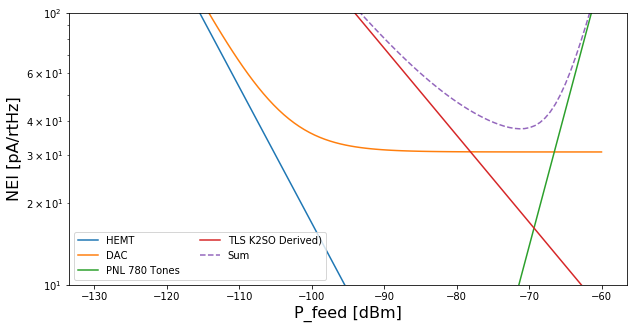

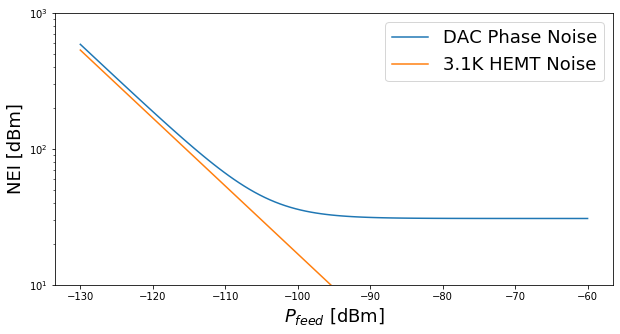

In [197]:
plt.figure(figsize = (10,5))
P_feed_sweep = np.linspace(-130,-60,100)
N = 780
dBc = 100
T_H = T_HEMT
f_r = 5e9
Pref = -75
kb = 1.38064852e-23

NEI_HEMT_P = nr.TN_to_NEI(T_H,P_feed_sweep,Qr,Qc,f_r,dfdI)

lossin, _, P_in = find_P_in_from_P_feed(P_feed_sweep, f_r)
T_DAC_P = nr.refer_phase_noise_to_K(dBc,lossin,Tavgin,P_in,Qr,Qc,f_r,dfdI)
dBc_new = -(10*np.log10(kb*T_DAC_P/0.001)-P_feed_sweep)
#NEI_DAC_P = nr.TN_to_NEI(T_DAC_P,P_feed_sweep,Qr,Qc,f_r,dfdI)
def find_NEI_give_dBc_phi(dBc,dfdI,Qr,f0,Qc):
    return 10**((-dBc)/20)*(f0*(Qc-Qr))/(2*Qr**2)/dfdI
NEI_DAC_P = find_NEI_give_dBc_phi(dBc_new,dfdI,Qr,f_r,Qc)

b = 1.4052833686612166e+23
T_PNL_P = b*np.asarray(10**(P_feed_sweep/10)*0.001)**3*N**3
NEI_PNL_P = nr.TN_to_NEI(T_PNL_P,P_feed_sweep,Qr,Qc,f_r,dfdI)

a1=-0.32
b1 = -1.01
#P in mW
NEI_TLS = 10**(a1*np.log10(10**(P_feed_sweep/10)) + b1)

NEI_TOT = np.sqrt(NEI_HEMT_P**2+NEI_DAC_P**2+NEI_PNL_P**2)

print(f'Frequency: {f_r/1e9} GHz')
print(f'TLS: {NEI_TLS[np.argmin(np.abs(P_feed_sweep-Pref))]}')
print(f'DAC: {NEI_DAC_P[np.argmin(np.abs(P_feed_sweep-Pref))]}')
print(f'PNL: {NEI_PNL_P[np.argmin(np.abs(P_feed_sweep-Pref))]}')
print(f'Total: {np.sqrt(NEI_TOT[np.argmin(np.abs(P_feed_sweep-Pref))]**2+NEI_TLS[np.argmin(np.abs(P_feed_sweep-Pref))]**2)}')

plt.semilogy(P_feed_sweep, NEI_HEMT_P,label = 'HEMT')
plt.semilogy(P_feed_sweep, NEI_DAC_P,label = 'DAC')
plt.semilogy(P_feed_sweep, NEI_PNL_P,label = f'PNL {N} Tones')
plt.semilogy(P_feed_sweep, NEI_TLS,label = 'TLS K2SO Derived)')
plt.semilogy(P_feed_sweep, 
             np.sqrt(NEI_TOT**2+NEI_TLS**2),
             label = 'Sum',ls = '--')

plt.xlabel('P_feed [dBm]',fontsize = 16)
plt.ylabel('NEI [pA/rtHz]',fontsize = 16)
plt.ylim(10,100)
#plt.axhline(45,ls = ':')

Meas_Noise = {}
Meas_Noise[0]= 48.53
Meas_Noise[1]= 61.52
Meas_Noise[2]= 56.77
Meas_Noise[3]= 60.92
Meas_Noise[4]= 48.16
Meas_Noise[5]= 47.54
Meas_Noise[6]= 48.94
Meas_Noise[7]= 68.37
P_tot = 0
for band in range(8):
    if band < 4:
        markerstyle = 'D'
    else:
        markerstyle = 'P'
    plt.plot(P_band[band],Meas_Noise[band],marker = markerstyle,label = f'Band {band} Measured',markersize = 8)
    P_tot += P_band[band]
P_tot /= 8
#plt.plot(P_tot,68.27,marker = '*',label = 'All Bands Measured',markersize = 12)
plt.legend(fontsize = 10,ncol = 2,loc='lower left')
print(Qr,Qc)

# Using actual Cv4 yielded data

## Loading SQUID Data

In [34]:
sq_data = np.genfromtxt('/home/msilvafe/Documents/Cv4_for_Delta_Review/1606334343_fr_sweep_data_fix_df_fits.dat',
             dtype =float,
             names = True, autostrip = True,unpack = True)


In [35]:
sq_data.dtype

dtype([('band', '<f8'), ('channel', '<f8'), ('fres_mhz', '<f8'), ('max_fit_fres_mhz', '<f8'), ('min_fit_fres_mhz', '<f8'), ('phi0_ff', '<f8'), ('phi0_offset', '<f8'), ('df_khz', '<f8'), ('hhpwr', '<f8'), ('avg_dfdphi_Hzperuphi0', '<f8')])

## Load Resonator Fit Data

In [36]:
import pandas as pd

In [37]:
fit_data = pd.read_csv('/home/msilvafe/Documents/Cv4_for_Delta_Review/Cv4_params.csv')

In [38]:
fit_data

,time,resonator_index,f0,Qi,Qc,Q,br,depth
0,1604591512,281.0,4007.552882,95070.245342,34732.715229,25438.924842,0.078768,11.036731
1,1604591512,57.0,4009.445879,83767.173466,33801.518216,24083.432411,0.083241,10.496790
2,1604591512,121.0,4011.483366,82060.391703,32618.551479,23340.737514,0.085933,10.607802
3,1604591512,313.0,4013.950985,97484.595807,31095.146387,23575.236078,0.085131,11.988731
4,1604591512,377.0,4015.836298,104959.872027,40247.376766,29091.932737,0.069020,10.852702
...,...,...,...,...,...,...,...,...
1677,1604599316,3642.0,7968.975494,51159.947072,119135.671277,35790.554660,0.111328,2.828894
1678,1604599316,3706.0,7971.148680,61802.850443,92467.528175,37043.772536,0.107591,3.532841
1679,1604599316,3898.0,7973.490320,123274.995845,55665.721207,38348.966426,0.103960,4.695816
1680,1604599316,3962.0,7975.614124,121726.488746,58095.777328,39326.581405,0.101402,4.443480


In [39]:
fit_data.loc[0,:]

time               1.604592e+09
resonator_index    2.810000e+02
f0                 4.007553e+03
Qi                 9.507025e+04
Qc                 3.473272e+04
Q                  2.543892e+04
br                 7.876813e-02
depth              1.103673e+01
Name: 0, dtype: float64

### Match SQUID Data and Res Fit Data

In [40]:
combo_dict = {}
combo_dict['chans'] = []
combo_dict['sq_idx'] = []
combo_dict['res_fit_idx'] = []
for i,ch in enumerate(sq_data['channel']):
    if np.min(np.abs(fit_data["f0"]-sq_data["fres_mhz"][i])) > 1:
        continue
    if ch < 512//2:
        continue
    combo_dict['chans'].append(ch)
    combo_dict['sq_idx'].append(i)
    combo_dict['res_fit_idx'].append(np.argmin(np.abs(fit_data["f0"]-sq_data["fres_mhz"][i])))
    #print(f'channel: {ch}, SQ f0: {sq_data["fres_mhz"][i]}, Res fit f0: {fit_data["f0"][np.argmin(np.abs(fit_data["f0"]-sq_data["fres_mhz"][i]))]}')

### Get Non-linearity noise temps

In [ ]:
import pickle as pkl
NL_noise = pkl.load(open('/home/msilvafe/Documents/Cv4_for_Delta_Review/Cv4_Simulated_Noise.pkl','rb'))

In [ ]:
NL_noise.keys()

In [ ]:
for ntones in [881,462,221]:
    f = NL_noise[ntones]['ADC']['f_WperHz']                                                        
    T = NL_noise[ntones]['ADC']['K']      
    f = f[:len(f)//2]          
    T = T[:len(T)//2]     
    plt.semilogy(f,T,alpha = 0.5,label = f'{ntones}')    
    plt.xlim(4e9,4.5e9)  
    plt.ylim(1e-4,10)
plt.legend()

### Calculate noise per channel

In [ ]:
def dfduPhi0_to_dfdI(dfduphi0,M_in):
    M_in_phi0_per_A = M_in/2.067833848e-15 #Phi0/A = [Wb/A]/[Wb/Phi0]
    dfdphi0 = dfduphi0*1e6 #Hz/phi0 = [Hz/uphi0]*[uphi0/phi0]
    dfdI_Hz_per_A = dfdphi0*M_in_phi0_per_A #Hz/A = [HZ/Phi0]*[Phi0/A]
    dfdI_Hz_per_pA = dfdI_Hz_per_A*1e-12 #Hz/pA = [Hz/A]*[A/pA]
    return dfdI_Hz_per_pA

In [ ]:
#Constants
P_feed = -80
P_in = P_feed + np.sum(lossin)

In [ ]:
combo_dict['calc_dac'] = []
combo_dict['dfdI'] = []
combo_dict['T_dac'] = []
combo_dict['calc_hemt'] = []
combo_dict['pnl_T_881'] = []
combo_dict['pnl_T_462'] = []
combo_dict['pnl_NEI_881'] = []
combo_dict['pnl_NEI_462'] = []
#plt.figure(1)
#plt.semilogy(NL_noise[881]['ADC']['f_WperHz'],
#             NL_noise[881]['ADC']['K'],alpha = 0.5)
#plt.xlim(4e9,4.5e9)
#plt.ylim(1e-2,10)
#plt.figure(2)
#plt.semilogy(NL_noise[462]['ADC']['f_WperHz'],
#             NL_noise[462]['ADC']['K'],alpha = 0.5)
#plt.xlim(4e9,4.5e9)
#plt.ylim(1e-2,10)

for i1,i2 in zip(combo_dict['sq_idx'], combo_dict['res_fit_idx']):
    Qr = fit_data.loc[i2,:]["Q"]
    Qc = fit_data.loc[i2,:]["Qc"]
    fr = fit_data.loc[i2,:]["f0"]*1e6
    
    f881 = NL_noise[881]['ADC']['f_WperHz']                                                        
    T881 = NL_noise[881]['ADC']['K']      
    f881 = f881[:len(f881)//2]          
    T881 = T881[:len(T881)//2]    
    imin881 = np.argmin(np.abs(f881-(fr-1e6)))
    imax881 = np.argmin(np.abs(f881-(fr+1e6)))
    #print(imin881, fr-1e6,imax881,fr+1e6)
    Tn881 = np.max(T881[imin881:imax881])
    combo_dict['pnl_T_881'].append(Tn881)
    #plt.figure(1)
    #plt.semilogy(np.asarray(f881[imin881:imax881]),
    #         T881[imin881:imax881],alpha = 0.7,color = 'r')
             
    f462 = NL_noise[462]['ADC']['f_WperHz']                                                        
    T462 = NL_noise[462]['ADC']['K']      
    f462 = f462[:len(f462)//2]          
    T462 = T462[:len(T462)//2]    
    imin462 = np.argmin(np.abs(f462 -(fr-1e6)))
    imax462 = np.argmin(np.abs(f462-(fr+1e6)))
    Tn462 = np.max(T462[imin462:imax462])
    combo_dict['pnl_T_462'].append(Tn462)
    #plt.figure(2)
    #plt.semilogy(np.asarray(f462[imin462:imax462])
    #        ,T462[imin462:imax462],alpha = 0.7,color = 'r')
    
    dfdI = dfduPhi0_to_dfdI(sq_data['avg_dfdphi_Hzperuphi0'][i1],227e-12)
    combo_dict['dfdI'].append(dfdI)
    Tdac = nr.refer_phase_noise_to_K(100,lossin,Tavgin,P_in,Qr,Qc,fr,dfdI)
    combo_dict['T_dac'].append(Tdac)
    
    combo_dict['calc_dac'].append(nr.TN_to_NEI(Tdac,P_feed,Qr,Qc,fr,dfdI))
    combo_dict['calc_hemt'].append(nr.TN_to_NEI(T_HEMT,P_feed,Qr,Qc,fr,dfdI))
    combo_dict['pnl_NEI_881'].append(nr.TN_to_NEI(Tn881,P_feed,Qr,Qc,fr,dfdI))
    combo_dict['pnl_NEI_462'].append(nr.TN_to_NEI(Tn462,P_feed,Qr,Qc,fr,dfdI))   
    

In [ ]:
tot_noise_462 = np.sqrt(np.asarray(combo_dict['calc_dac'])**2 + np.asarray(combo_dict['calc_hemt'])**2 + np.asarray(combo_dict['pnl_NEI_462'])**2)
tot_noise_881 = np.sqrt(np.asarray(combo_dict['calc_dac'])**2 + np.asarray(combo_dict['calc_hemt'])**2 + np.asarray(combo_dict['pnl_NEI_881'])**2)

plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
plt.hist(combo_dict['calc_dac'],bins = np.logspace(-1,2,20),alpha = 0.5,
         label = 'DAC')
plt.axvline(np.median(combo_dict['calc_dac']),color = 'k',ls = ':',
           label = f'DAC: {np.round(np.median(combo_dict["calc_dac"]),2)}')

plt.hist(combo_dict['calc_hemt'],bins = np.logspace(-1,1,20),alpha = 0.5,
         label = 'HEMT')
plt.axvline(np.median(combo_dict['calc_hemt']),color = 'k',ls = '-.',
            label = f'HEMT: {np.round(np.median(combo_dict["calc_hemt"]),2)}')

plt.hist(combo_dict['pnl_NEI_462'],bins = np.logspace(-1,1,20),alpha = 0.5,
         label = 'PNL 462 Tones')
plt.axvline(np.median(combo_dict['pnl_NEI_462']),color = 'k',ls = '--',
            label = f'PNL 462 Tones: {np.round(np.median(combo_dict["pnl_NEI_462"]),2)}')

plt.hist(combo_dict['pnl_NEI_881'],bins = np.logspace(-1,1,20),alpha = 0.5,
         label = 'PNL 881 Tones')
plt.axvline(np.median(combo_dict['pnl_NEI_881']),color = 'k',ls = '-',
           label = f'PNL 881 Tones: {np.round(np.median(combo_dict["pnl_NEI_881"]),2)}')

plt.title('Simulated Noise Sources',fontsize = 24)
plt.xlabel('NEI [pA/rtHz]',fontsize = 24)
plt.xscale('log')
plt.legend(fontsize = 12)

plt.subplot(1,2,2)
plt.hist(tot_noise_462[np.where(tot_noise_462 <200)[0]],bins = np.logspace(0,2,20),
         alpha = 0.5,color = 'r',label = 'Total 462 Tones')
plt.axvline(np.median(tot_noise_462),color = 'r', ls = '--',
            label = f'Total 462 Tones: {np.round(np.median(tot_noise_462),2)}')
        
plt.hist(tot_noise_881[np.where(tot_noise_881 <200)[0]],bins = np.logspace(0,2,20),
         alpha = 0.5,color = 'b',label = 'Total 881 Tones')
plt.axvline(np.median(tot_noise_881),color = 'r', ls = '-',
            label = f'Total 881 Tones: {np.round(np.median(tot_noise_881),2)}')

plt.title('Quadrature Sum of Simulated Noise Sources',fontsize = 24)
plt.xlabel('NEI [pA/rtHz]',fontsize = 24)
plt.xscale('log')
plt.legend(fontsize = 12,loc = 'upper left')
#plt.figure()
#plt.hist(fit_data.loc[combo_dict['res_fit_idx'],:]['Q'],bins = np.linspace(10e3,80e3,20))
#plt.figure()
#plt.hist(fit_data.loc[combo_dict['res_fit_idx'],:]['Qc'],bins = np.linspace(10e3,100e3,20))
#plt.figure()
#plt.hist(fit_data.loc[combo_dict['res_fit_idx'],:]['Qi'],bins = np.linspace(30e3,300e3,20))

In [ ]:
plt.plot(np.asarray(combo_dict['dfdI'])[np.where(tot_noise_881<200)[0]]/1e-3,tot_noise_881[np.where(tot_noise_881<200)[0]],'o')
plt.xlabel('<df/dI> [mHz/pA]',fontsize = 16)
plt.ylabel('NEI [pA/rtHz]',fontsize = 16)
plt.xlim(14,26)
plt.ylim(0,60)

## Load Measured Data for Comparison

In [41]:
meas_dat = pkl.load(open('/home/msilvafe/Documents/Cv4_for_Delta_Review/cv4_400_noise_dict.pkl','rb'))

In [42]:
meas_dat.keys()

dict_keys([0, 1, 2, 3])

In [43]:
chans_compare = []
for key in meas_dat[0].keys():
    if key in sq_data['channel']:
        chans_compare.append(key)

In [44]:

for i in combo_dict['sq_idx']:
    

SyntaxError: unexpected EOF while parsing (<ipython-input-44-57a6628f03ca>, line 2)

Check against Shawn's Calc

In [23]:
Qi_s = 200e3
BW_s = 100e3
f0_s = 6e9
dfdphi = 0.029
Min = 227e-12
dBc = 100

In [24]:
def dfdurad_to_dfdI(dfdurad,M_in):
    dfduphi0 = dfdurad*2*pi #Hz/uPhi0 = [Hz/urad]*[rad/phi0]
    M_in_phi0_per_A = M_in/2.067833848e-15 #Phi0/A = [Wb/A]/[Wb/Phi0]
    dfdphi0 = dfduphi0*1e6 #Hz/phi0 = [Hz/uphi0]*[uphi0/phi0]
    dfdI_Hz_per_A = dfdphi0*M_in_phi0_per_A #Hz/A = [HZ/Phi0]*[Phi0/A]
    dfdI_Hz_per_pA = dfdI_Hz_per_A*1e-12 #Hz/pA = [Hz/A]*[A/pA]
    return dfdI_Hz_per_pA

In [25]:
dfdI = dfdurad_to_dfdI(dfdphi,Min)
Qr_s = f0_s/BW_s
Qc_s = 1/((1/Qr_s)-(1/Qi_s))
print(dfdI,Qr_s,Qc_s)

0.02000267522323835 60000.0 85714.28571428571


In [26]:
_, _, P_in_s = find_P_in_from_P_feed(-70, f0_s)
T_DAC_s = nr.refer_phase_noise_to_K(dBc,lossin,Tavgin,P_in_s,Qr_s,Qc_s,f0_s,dfdI)
NEI_DAC_s = nr.TN_to_NEI(T_DAC_s,-70,Qr_s,Qc_s,f0_s,dfdI)
print(NEI_DAC_s)

26.978357821765496


## DAC Noise vs Params:

49999.99999999999 85714.28571428571 40000.0 60000.0


Text(0.5, 1.0, 'SMuRF DAC Noise Single Tone vs Dip Depth')

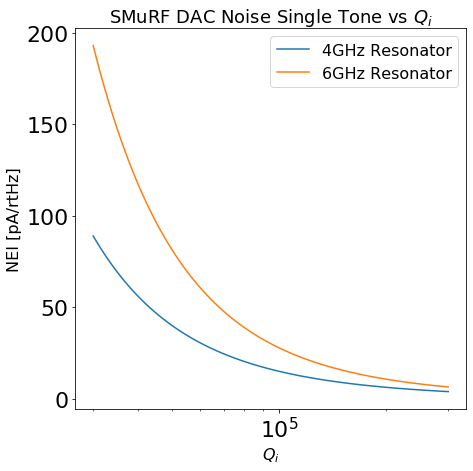

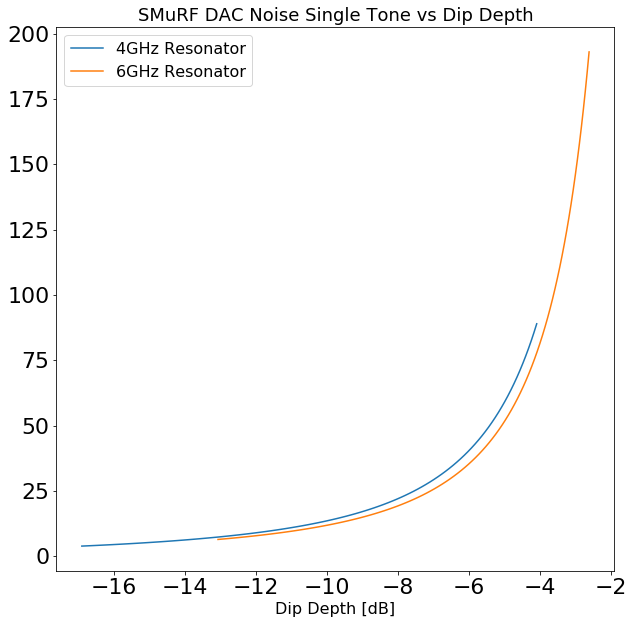

In [148]:
P_feed = -70
dfdI = 0.02
dBc = 100

#Assume Qc is chosen based on Qi = 200e3 and BW = 100e3
Qi_des = 200e3
BW_des = 100e3
Qr_fmin = 4e9/BW_des
Qr_fmax = 6e9/BW_des
Qc_fmin = 1/((1/Qr_fmin)-(1/Qi_des))
Qc_fmax = 1/((1/Qr_fmax)-(1/Qi_des))
print(Qc_fmin,Qc_fmax,Qr_fmin,Qr_fmax)

#Now sweep Qi and calculate Qr_min and Qr_max 
Qi = np.logspace(np.log10(30000),np.log10(300000),100)
Qr_min = []
Qr_max = []
T_dac_min = []
T_dac_max = []
for qi in Qi:
    Qr_min.append(1/((1/Qc_fmin)+(1/qi)))
    Qr_max.append(1/((1/Qc_fmax)+(1/qi)))

lossin_4, _, Pin4 = find_P_in_from_P_feed(-70,4e9)
lossin_6, _, Pin6 = find_P_in_from_P_feed(-70,6e9)
        
#Now sweep Qi and calculate Qr_min and Qr_max 
Qr_min = []
Qr_max = []
T_dac_min = []
T_dac_max = []
N_dac_min = []
N_dac_max = []
dip_depth_min = []
dip_depth_max = []
for qi in Qi:
    qr_min = (1/((1/Qc_fmin)+(1/qi)))
    qr_max = (1/((1/Qc_fmax)+(1/qi)))
    t_min = nr.refer_phase_noise_to_K(dBc,lossin_4,Tavgin,Pin4,qr_min,Qc_fmin,4e9,dfdI)
    t_max = nr.refer_phase_noise_to_K(dBc,lossin_6,Tavgin,Pin6,qr_max,Qc_fmax,6e9,dfdI)
    dBc_min = -(10*np.log10(kb*t_min/0.001)+70)
    dBc_max = -(10*np.log10(kb*t_max/0.001)+70)

    Qr_min.append(qr_min)
    Qr_max.append(qr_max)
    T_dac_min.append(t_min)
    T_dac_max.append(t_max)
    #n_min = nr.TN_to_NEI(t_min,P_feed,qr_min,Qc_fmin,4e9,dfdI)
    n_min = find_NEI_give_dBc_phi(dBc_min,dfdI,qr_min,4e9,Qc_fmin)
    #n_max = nr.TN_to_NEI(t_max,P_feed,qr_max,Qc_fmax,6e9,dfdI)
    n_max = find_NEI_give_dBc_phi(dBc_max,dfdI,qr_max,6e9,Qc_fmax)
    N_dac_min.append(n_min)
    N_dac_max.append(n_max)
    dip_depth_min.append(20*np.log10(1-(qr_min/Qc_fmin)))
    dip_depth_max.append(20*np.log10(1-(qr_max/Qc_fmax)))
    
plt.figure(figsize = (7,7))
#plt.subplot(1,2,1)
plt.semilogx(Qi,N_dac_min,label = '4GHz Resonator')
plt.semilogx(Qi,N_dac_max,label = '6GHz Resonator')
plt.xlabel('$Q_i$',fontsize = 16)
plt.ylabel('NEI [pA/rtHz]',fontsize = 16)
plt.title('SMuRF DAC Noise Single Tone vs $Q_i$',fontsize = 18)
plt.legend()
plt.figure(figsize = (10,10))
#plt.subplot(1,2,2)
plt.plot(dip_depth_min,N_dac_min, label = '4GHz Resonator')
plt.plot(dip_depth_max,N_dac_max, label = '6GHz Resonator')
plt.legend()
plt.xlabel('Dip Depth [dB]',fontsize = 16)
plt.title('SMuRF DAC Noise Single Tone vs Dip Depth',fontsize = 18)

In [12]:
Qi = 200e3
Qr = 60000
Qc = 85714.29
dfdI = 0.02
dBc = 101
k_b = 1.38e-23

T4 = nr.refer_phase_noise_to_K(dBc,lossin_4,Tavgin,Pin4,Qr,Qc,4e9,dfdI)
T6 = nr.refer_phase_noise_to_K(dBc,lossin_6,Tavgin,Pin6,Qr,Qc,6e9,dfdI)
print(T4,T6)
print(Pin4,Pin4-np.sum(lossin_4))
print(10**((-70-dBc)/10)*0.001/k_b)

N4 = nr.TN_to_NEI(T4,-70,Qr,Qc,4e9,dfdI)
N6 = nr.TN_to_NEI(T6,-70,Qr,Qc,6e9,dfdI)
print(N4,N6)

576.6649482583904 576.4350373864193
-36.051484877287606 -70.0
575.6001700900572
15.018862933463248 22.523803043313748


In [82]:
print(f'BW 4GHz: {4e9/Qr}',f'BW 6GHz: {6e9/Qr}',f'dfdI: {dfdI}',f'P into cryostat 4GHz: {Pin4}\n',
     f'P into cryostat 6 GHz: {Pin6}',f'Loss into cryostat 4GHz: {np.sum(lossin_4)}\n',
     f'Loss into cryostat 6GHz: {np.sum(lossin_6)}', f'SMuRF dBc: {dBc}\n', f'Qr: {Qr}',
     f'Qi: {Qi}',f'Qc: {Qc}', 'P at resonator: -70.0')

BW 4GHz: 80000.0 BW 6GHz: 120000.0 dfdI: 0.02 P into cryostat 4GHz: -36.051484877287606
 P into cryostat 6 GHz: -34.911491861138046 Loss into cryostat 4GHz: 35.088508138861954
 Loss into cryostat 6GHz: 35.088508138861954 SMuRF dBc: 100
 Qr: 50000.0 Qi: 200000.0 Qc: 66666.66666666666 P at resonator: -70.0


35.088508138861954

In [75]:
lossin

array([3.3842367713004498, 0.06, 1.1103139013452918, 0.06, 0.06,
       3.1245628378378383, 0.33, 0.06, 3.606871621621622, 0.33, 10.0,
       0.06, 2.2138054054054055, 0.06, 2.139845168918919, 0.06,
       2.2088724324324325, 6.0, 0.06, 0.16], dtype=object)

In [76]:
np.sum(lossin)

35.088508138861954

# Multi-Tone Noise vs Dip Depth

Sum: 21.48840872724707
Pseudo Noise: 3.5203289799353863
HEMT: 1.8452037545916484
DAC: 12.55193476296125
TLS: 16.98243652461745
66666.66666666666


<Figure size 576x504 with 0 Axes>

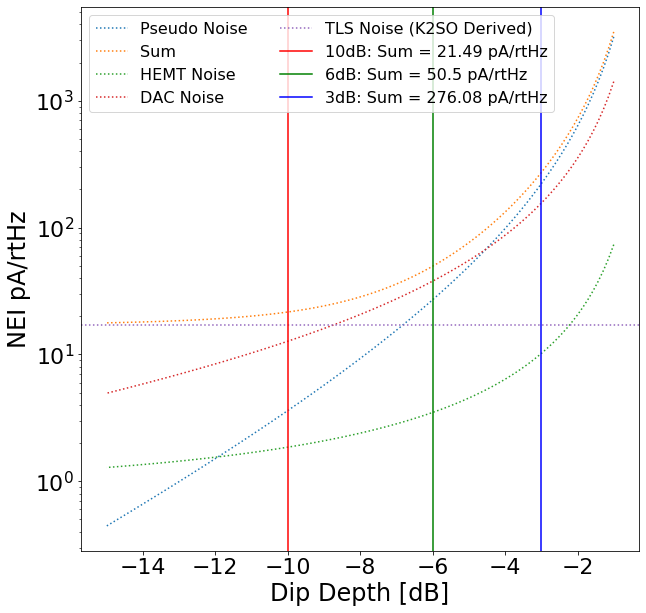

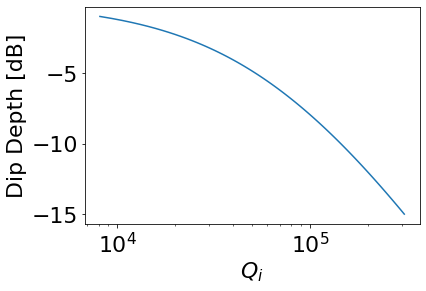

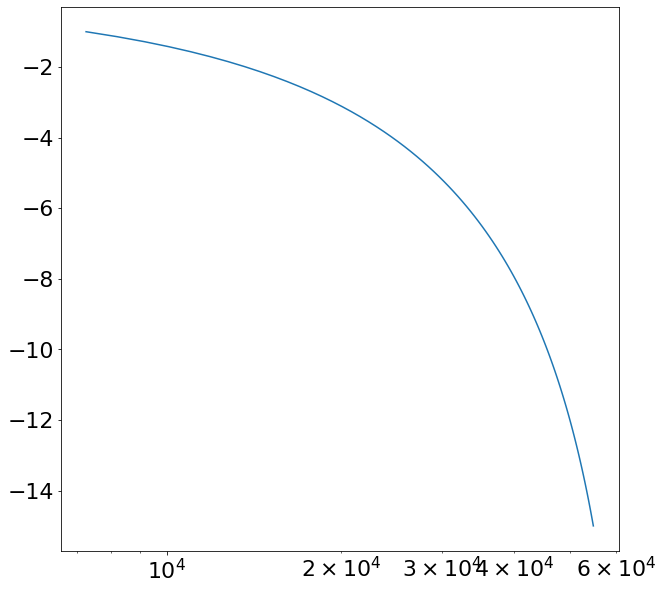

In [149]:
P_feed = -70
f_mean = 5e9
lossin, _, P_in = find_P_in_from_P_feed(P_feed, f_mean)
TH = T_HEMT
dBc = 100
N_tones_plot = 1000

plt.figure(figsize = (8,7))

Qi_des = 200e3
BW_des = 100e3
Qr_des = f_mean/BW_des
Qc = 1/((1/Qr_des)-(1/Qi_des))
Dip_depth_plot = np.linspace(-1,-15,100)
Dip_depth_lin = 10**(Dip_depth_plot/20)
Qr = (1-Dip_depth_lin)*Qc
Qi = 1/((1/Qr)-(1/Qc))
P_feed_lin = 0.001*10**((P_feed+(Dip_depth_plot+6.4))/10)

NEI_HEMT_P = nr.TN_to_NEI(TH,P_feed,Qr,Qc,f_mean,dfdI)

T_DAC_P = nr.refer_phase_noise_to_K(dBc,lossin,Tavgin,P_in,Qr,Qc,f_mean,dfdI)
#NEI_DAC_P = nr.TN_to_NEI(T_DAC_P,P_feed,Qr,Qc,f_mean,dfdI)
dBc_new = -(10*np.log10(kb*T_DAC_P/0.001)-P_feed)
NEI_DAC_P = find_NEI_give_dBc_phi(dBc_new,dfdI,Qr,f_mean,Qc)

##-6.4dB ref
b = 1.4052833686612166e+23
T_NL = b*P_feed_lin**3*N_tones_plot**3
NEI_NL_plot = nr.TN_to_NEI(T_NL,
                           P_feed,Qr,Qc,f_mean,dfdI)

a1=-0.32
b1 = -1.01
#P in mW
NEI_TLS_P = 10**(a1*np.log10(10**(P_feed/10)) + b1)

NEI_tot_plot = np.sqrt(NEI_TLS_P**2 + NEI_HEMT_P**2 + NEI_DAC_P**2 + NEI_NL_plot**2)

#plt.loglog(N_tones_sweep,NEI_NL,'o',color = 'C0')  
plt.figure(figsize = (10,10))
plt.semilogy(Dip_depth_plot,NEI_NL_plot,':',color = 'C0',label = 'Pseudo Noise')
plt.semilogy(Dip_depth_plot,NEI_tot_plot,':',color = 'C1',label = 'Sum')
plt.semilogy(Dip_depth_plot,NEI_HEMT_P,color = 'C2',ls = ':',label = 'HEMT Noise')
plt.semilogy(Dip_depth_plot,NEI_DAC_P,color = 'C3',ls = ':',label = 'DAC Noise')
plt.axhline(NEI_TLS_P,color = 'C4',ls = ':',label = 'TLS Noise (K2SO Derived)')
plt.axvline(-10,color = 'r',ls = '-',
            label = f'10dB: Sum = {np.round(NEI_tot_plot[np.argmin(np.abs(Dip_depth_plot + 10))],2)} pA/rtHz')
plt.axvline(-6,color = 'g',ls = '-',
            label = f'6dB: Sum = {np.round(NEI_tot_plot[np.argmin(np.abs(Dip_depth_plot + 6))],2)} pA/rtHz')
plt.axvline(-3,color = 'b',ls = '-',
            label = f'3dB: Sum = {np.round(NEI_tot_plot[np.argmin(np.abs(Dip_depth_plot + 3))],2)} pA/rtHz')
plt.legend(ncol=2)
#plt.legend(['Pseudo Noise','Sum','HEMT Noise','DAC Noise','850 Tones'])
plt.xlabel('Dip Depth [dB]',fontsize = 24)
plt.ylabel('NEI pA/rtHz',fontsize = 24)
#plt.ylim(1,100)

print(f'Sum: {NEI_tot_plot[np.argmin(np.abs(Dip_depth_plot + 10))]}')
print(f'Pseudo Noise: {NEI_NL_plot[np.argmin(np.abs(Dip_depth_plot + 10))]}')
print(f'HEMT: {NEI_HEMT_P[np.argmin(np.abs(Dip_depth_plot + 10))]}')
print(f'DAC: {NEI_DAC_P[np.argmin(np.abs(Dip_depth_plot + 10))]}')
print(f'TLS: {NEI_TLS_P}')
#plt.xlim(200,1000)

plt.figure()
plt.semilogx(Qi,Dip_depth_plot)
plt.xlabel('$Q_i$')
plt.ylabel('Dip Depth [dB]')

plt.figure(figsize = (10,10))
plt.semilogx(Qr,Dip_depth_plot)
print(Qc)

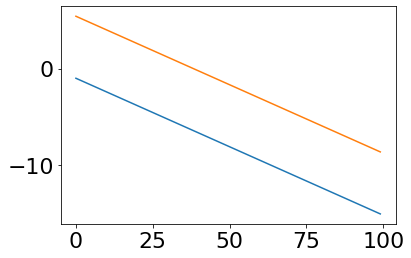

In [70]:
plt.plot(Dip_depth_plot)
plt.plot(Dip_depth_plot+6.4)

## DAC Noise vs Attenuator Placement

In [217]:
c = pd.read_csv(dirname+'InputChain.csv', delimiter=',')
d = np.transpose(c.values)
compin = d[0,:]
lossin = d[1,:]
Tavgin = (d[2,:]+d[3,:])/2
coax_YNin = d[4,:]
coax_typein = d[5,:]
coax_lin = d[6,:]
for i in range(len(compin)):
    if coax_YNin[i] == 'Y':
        t = nr.readcoax(dirname+coax_typein[i]+'.csv',6)
        lossin[i] = (t[0]*Tavgin[i]+t[1])*coax_lin[i]

In [218]:
att40K = 6
att4K = 3
att1K = 3
att0p1K = 1
print(np.sum(lossin),sum([lossin[3],lossin[6],lossin[15],lossin[18]]))
lossin[3] = att40K
lossin[6] = att4K
lossin[15] = att1K
lossin[18] = att0p1K
print(np.sum(lossin),sum([lossin[3],lossin[6],lossin[15],lossin[18]]))

30.48331082159738 11.631512432432432
31.851798389164948 13


In [219]:
def get_Pin(P_feed,lossin):
    return P_feed + np.sum(lossin)

In [220]:
P_feed = -70
P_in = get_Pin(P_feed,lossin)

In [221]:
kb = 1.38064852e-23
print('P in:',P_in)
T_DAC = (10**((P_in - 100)/10)*0.001)/kb
print('T DAC',np.round(T_DAC,2), 'K')
T_300K_Referred = nr.ref_noise_temp(lossin,Tavgin,T_DAC)
print('300K referred =', np.round(T_300K_Referred,2), 'K')
N_refd = 10*np.log10(T_300K_Referred*kb/0.001)
print(N_refd)
print(P_feed)
SNR = N_refd-P_feed
print(SNR)

P in: -38.14820161083505
T DAC 1109421.83 K
300K referred = 725.44 K
-169.99313339092538
-70
-99.99313339092538


"plt.subplot(2,2,3)\nplt.plot(P_feed_sweep,T_DAC_P1 - (dBc_to_K_300K(P_in,100)*10**(np.sum(-lossin)/10)))\nplt.plot(P_feed_sweep,T_DAC_P2 - (dBc_to_K_300K(P_in2,100)*10**(np.sum(-lossin2)/10)))\nplt.plot(P_feed_sweep,T_DAC_P3 - (dBc_to_K_300K(P_in3,100)*10**(np.sum(-lossin3)/10)))\n#plt.ylim(-1,1)\nplt.yscale('log')"

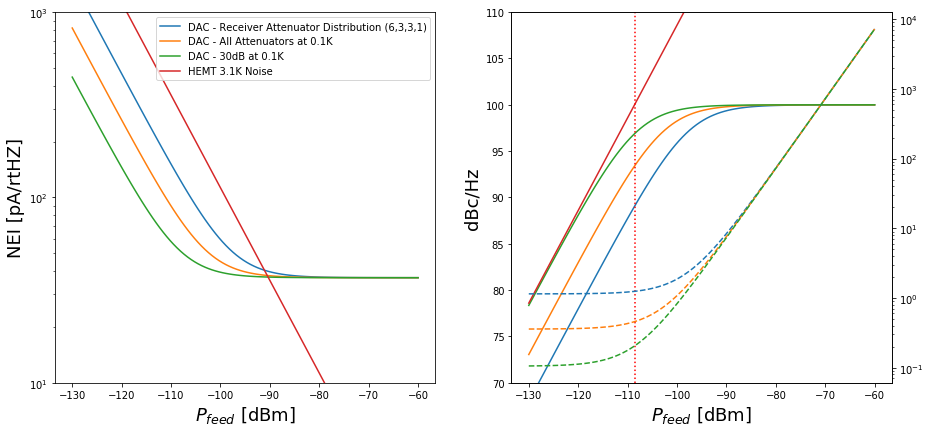

In [296]:
plt.figure(figsize = (15,15))
plt.subplot(2,2,1)
P_feed_sweep = np.linspace(-130,-60,100)
N = 780
dBc = 100
T_H = T_HEMT
f_r = 6e9
Pref = -75
kb = 1.38064852e-23

NEI_HEMT_P = nr.TN_to_NEI(T_H,P_feed_sweep,Qr,Qc,f_r,dfdI)
NEI_0p1K_P = nr.TN_to_NEI(0.1,P_feed_sweep,Qr,Qc,f_r,dfdI)


#lossin, _, P_in = find_P_in_from_P_feed(P_feed_sweep, f_r)
P_in = get_Pin(P_feed_sweep,lossin)
T_DAC_P1 = nr.refer_phase_noise_to_K(dBc,lossin,Tavgin,P_in,Qr,Qc,f_r,dfdI)
dBc_new = -(10*np.log10(kb*T_DAC_P1/0.001)-P_feed_sweep)
#NEI_DAC_P = nr.TN_to_NEI(T_DAC_P,P_feed_sweep,Qr,Qc,f_r,dfdI)
def find_NEI_give_dBc_phi(dBc,dfdI,Qr,f0,Qc):
    return 10**((-dBc)/20)*(f0*(Qc-Qr))/(2*Qr**2)/dfdI
NEI_DAC_P = find_NEI_give_dBc_phi(dBc_new,dfdI,Qr,f_r,Qc)

lossin2 = np.copy(lossin)
lossin2[3] = 0
lossin2[6] = 0
lossin2[15] = 0
lossin2[18] = 13
P_in2 = get_Pin(P_feed_sweep,lossin2)
T_DAC_P2 = nr.refer_phase_noise_to_K(dBc,lossin2,Tavgin,P_in2,Qr,Qc,f_r,dfdI)
dBc_new2 = -(10*np.log10(kb*T_DAC_P2/0.001)-P_feed_sweep)
NEI_DAC_P2 = find_NEI_give_dBc_phi(dBc_new2,dfdI,Qr,f_r,Qc)

lossin3 = np.copy(lossin)
lossin3[3] = 0
lossin3[6] = 0
lossin3[15] = 0
lossin3[18] = 30
P_in3 = get_Pin(P_feed_sweep,lossin3)
T_DAC_P3 = nr.refer_phase_noise_to_K(dBc,lossin3,Tavgin,P_in3,Qr,Qc,f_r,dfdI)
dBc_new3 = -(10*np.log10(kb*T_DAC_P3/0.001)-P_feed_sweep)
NEI_DAC_P3 = find_NEI_give_dBc_phi(dBc_new3,dfdI,Qr,f_r,Qc)

plt.plot(P_feed_sweep, NEI_DAC_P,label = 'DAC - Receiver Attenuator Distribution (6,3,3,1)')
plt.plot(P_feed_sweep, NEI_DAC_P2,label = 'DAC - All Attenuators at 0.1K')
plt.plot(P_feed_sweep, NEI_DAC_P3,label = 'DAC - 30dB at 0.1K')
plt.plot(P_feed_sweep, NEI_HEMT_P,label = 'HEMT 3.1K Noise')
#plt.plot(P_feed_sweep, NEI_0p1K_P,label = '100mK Noise Temperature Noise Source')
plt.ylim(10,1000)
plt.yscale('log')
plt.legend(fontsize = 10,loc = 'upper right')
plt.xlabel('$P_{feed}$ [dBm]',fontsize = 18)
plt.ylabel('NEI [pA/rtHZ]',fontsize = 18)

plt.subplot(2,2,2)
plt.plot(P_feed_sweep,dBc_new,label = 'DAC - Receiver Attenuator Distribution (6,3,3,1)')
plt.plot(P_feed_sweep,dBc_new2,label = 'DAC - All Attenuators at 0.1K')
plt.plot(P_feed_sweep,dBc_new3,label = 'DAC - 30dB at 0.1K')
plt.plot(P_feed_sweep,-(10*np.log10(kb*0.1/0.001)-P_feed_sweep),label = '0.1K Thermal Noise')
plt.xlabel('$P_{feed}$ [dBm]',fontsize = 18)
plt.ylabel('dBc/Hz',fontsize = 18)
plt.axvline(10*np.log10(kb*0.1/0.001)+100,ls = ':',color = 'r',label = '$P_{feed}$ where 100dBc = 0.1K Thermal Noise')
plt.ylim(70,110)
ax = plt.gca()
ax2 = ax.twinx()
ax2.semilogy(P_feed_sweep,T_DAC_P1,'--')
ax2.semilogy(P_feed_sweep,T_DAC_P2,'--')
ax2.semilogy(P_feed_sweep,T_DAC_P3,'--')

'''plt.subplot(2,2,3)
plt.plot(P_feed_sweep,T_DAC_P1 - (dBc_to_K_300K(P_in,100)*10**(np.sum(-lossin)/10)))
plt.plot(P_feed_sweep,T_DAC_P2 - (dBc_to_K_300K(P_in2,100)*10**(np.sum(-lossin2)/10)))
plt.plot(P_feed_sweep,T_DAC_P3 - (dBc_to_K_300K(P_in3,100)*10**(np.sum(-lossin3)/10)))
#plt.ylim(-1,1)
plt.yscale('log')'''

#plt.subplot(2,2,4)

#plt.ylim(-1,1)
#ax2.yscale('log')

In [274]:
def dBc_to_K_300K(Pin, dBc):
    k_b = 1.38064852e-23
    return (10.**((Pin-dBc)/10.)*.001)/k_b

In [282]:
dBc_to_K_300K(-35,100)

2290429.181909658

In [283]:
np.sum(lossin)

31.851798389164948